In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('2024-06-19T12_22_18+00_00_1lln.csv')

In [3]:
print(data.shape)
#no head() function due to sensitive info

(23696, 35)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23696 entries, 0 to 23695
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EKLA Subscription Id               23696 non-null  object 
 1   Opportunity Name                   23696 non-null  object 
 2   Account Name: Acc.SF ID-18         23696 non-null  object 
 3   Account Name: Account Name         23696 non-null  object 
 4   Last Payment Date                  22703 non-null  object 
 5   Churn Date                         6332 non-null   object 
 6   Closed Won Time Stamp              23696 non-null  object 
 7   Status                             23696 non-null  object 
 8   Valid Until                        23672 non-null  object 
 9   Domain Page Count                  23184 non-null  float64
 10  Average Monthly Traffic            18662 non-null  float64
 11  Account Name: Count of Opps        23696 non-null  flo

## Data Preprocessing

First of all, to avoid data leakage, we will drop 2 columns:

- Churn Date - indicator for the customer churn

- EKLA Subscription Id - ID column

In [5]:
data.drop(columns=['EKLA Subscription Id', 'Churn Date'], inplace=True)

In [6]:
data.columns

Index(['Opportunity Name', 'Account Name: Acc.SF ID-18',
       'Account Name: Account Name', 'Last Payment Date',
       'Closed Won Time Stamp', 'Status', 'Valid Until', 'Domain Page Count',
       'Average Monthly Traffic', 'Account Name: Count of Opps', 'Auto Renew',
       'FN ARR', 'Whole License FN ARR', 'Auto Renew Turned Off Timestamp',
       'Total Payment Count', 'Website Category New', 'Category Rank',
       'CMS-Builder', 'Account Name: Funnel Type', 'Auto Renew Off_Reason',
       'Billing cycle', 'ARR Allocation', 'Account Name: Account Record Type',
       'Opp. Time in Active', 'Plan', '_id', 'licenseType', 'Account Name',
       'Acc.SF ID-18', 'Total ARR', 'Account Record Type',
       'Account CRM Entrance', 'asked_to_auto_renew_off'],
      dtype='object')

#### Feature Selection

We decided to remove some columns from our dataset:


- **Opportunity Name** - Customer domain unique vales for each row

- **Account Name: Acc.SF ID-18** - ID unique value for each row

- **Account Name: Account Name** - account name

- **Auto Renew** - correlated with the target variable

- **Auto Renew Turned Off Timestamp** - the time the customer has chruned,     correlated with the target variable - data leakage

- **Auto Renew Off_Reason** - data leakage

- **ARR Allocation** - only one unique value for the entire data

- **'Account Name: Account Record Type** - only one unique value for the entire data

- **_id** - ID

- **licenseType** -  only one unique value for the entire data

- **Account Name** - account name

- **Acc.SF ID-18** - ID

- **Account Record Type** - only one unique value for the entire data


To handle the date columns, we will calculate for each customer, the difference in days since he first joined

In [7]:
# Convert date columns to datetime
date_columns = ['Last Payment Date', 'Closed Won Time Stamp', 'Valid Until']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Calculate the difference in days
data['number_of_days_until_last_payment'] = (data['Last Payment Date'] - data['Closed Won Time Stamp']).dt.days
data['number_of_days_until_valid'] = (data['Valid Until'] - data['Closed Won Time Stamp']).dt.days

# Display the first few rows to verify the new columns
data[['Last Payment Date', 'Closed Won Time Stamp', 'Valid Until', 'number_of_days_until_last_payment', 'number_of_days_until_valid']].head()
data.drop(columns=['Last Payment Date', 'Closed Won Time Stamp', 'Valid Until'], inplace=True)

In [8]:
features = [
    'Status',
    'Domain Page Count',
    'Average Monthly Traffic',
    'Account Name: Count of Opps',
    'FN ARR',
    'Whole License FN ARR',
    'Total Payment Count',
    'Website Category New',
    'Category Rank',
    'CMS-Builder',
    'Account Name: Funnel Type',
    'Billing cycle',
    'Opp. Time in Active',
    'Plan',
    'Total ARR',
    'Account CRM Entrance',
    'number_of_days_until_last_payment',
    'number_of_days_until_valid',
    'asked_to_auto_renew_off'
]

data = data[features]

In [9]:
data.head()

,Status,Domain Page Count,Average Monthly Traffic,Account Name: Count of Opps,FN ARR,Whole License FN ARR,Total Payment Count,Website Category New,Category Rank,CMS-Builder,Account Name: Funnel Type,Billing cycle,Opp. Time in Active,Plan,Total ARR,Account CRM Entrance,number_of_days_until_last_payment,number_of_days_until_valid,asked_to_auto_renew_off
0,Unpaid,0.0,NaN,1.0,0.0,0.0,8.0,NaN,NaN,CMS Not Detected,Self Service,Monthly,0.0,Standard,NaN,NaN,214.0,245.0,1
1,Unpaid,12.0,NaN,3.0,0.0,0.0,3.0,NaN,NaN,Drupal,Self Service,Annually,0.0,Standard,NaN,NaN,733.0,1099.0,1
2,Unpaid,9230.0,1264179.0,2.0,0.0,0.0,26.0,Sports & Fitness/Sporting Goods,38.0,SiteCore,Self Service,Monthly,0.0,Advanced Plus,NaN,NaN,753.0,782.0,1
3,Unpaid,8.0,5020.0,1.0,0.0,0.0,3.0,"Dining & Nightlife/Dining & Nightlife Reviews,...",17729.0,Squarespace,Self Service,Annually,0.0,Standard,NaN,NaN,732.0,1099.0,0
4,Unpaid,307.0,6225.0,8.0,0.0,0.0,4.0,Hobbies & Leisure/Toys & Games,NaN,Shopify,Touched,Annually,0.0,Standard,980.0,EKLA Lead form,1097.0,1464.0,1


Checking NULL values

In [ ]:
data.isnull().sum()

Status                                   0
Domain Page Count                      512
Average Monthly Traffic               5034
Account Name: Count of Opps              0
FN ARR                                   0
Whole License FN ARR                     0
Total Payment Count                   1208
Website Category New                  6727
Category Rank                        15821
CMS-Builder                           2800
Account Name: Funnel Type                0
Billing cycle                            0
Opp. Time in Active                      0
Plan                                     0
Total ARR                             5507
Account CRM Entrance                  5509
number_of_days_until_last_payment      993
number_of_days_until_valid              24
asked_to_auto_renew_off                  0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23696 entries, 0 to 23695
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Status                             23696 non-null  object 
 1   Domain Page Count                  23184 non-null  float64
 2   Average Monthly Traffic            18662 non-null  float64
 3   Account Name: Count of Opps        23696 non-null  float64
 4   FN ARR                             23696 non-null  float64
 5   Whole License FN ARR               23696 non-null  float64
 6   Total Payment Count                22488 non-null  float64
 7   Website Category New               16969 non-null  object 
 8   Category Rank                      7875 non-null   float64
 9   CMS-Builder                        20896 non-null  object 
 10  Account Name: Funnel Type          23696 non-null  object 
 11  Billing cycle                      23696 non-null  obj

To decide how to fill the missing values we will observe the features distributions

In [ ]:
data['Domain Page Count'].min(), data['Domain Page Count'].max(), data['Domain Page Count'].median()

(0.0, 103000000.0, 49.0)

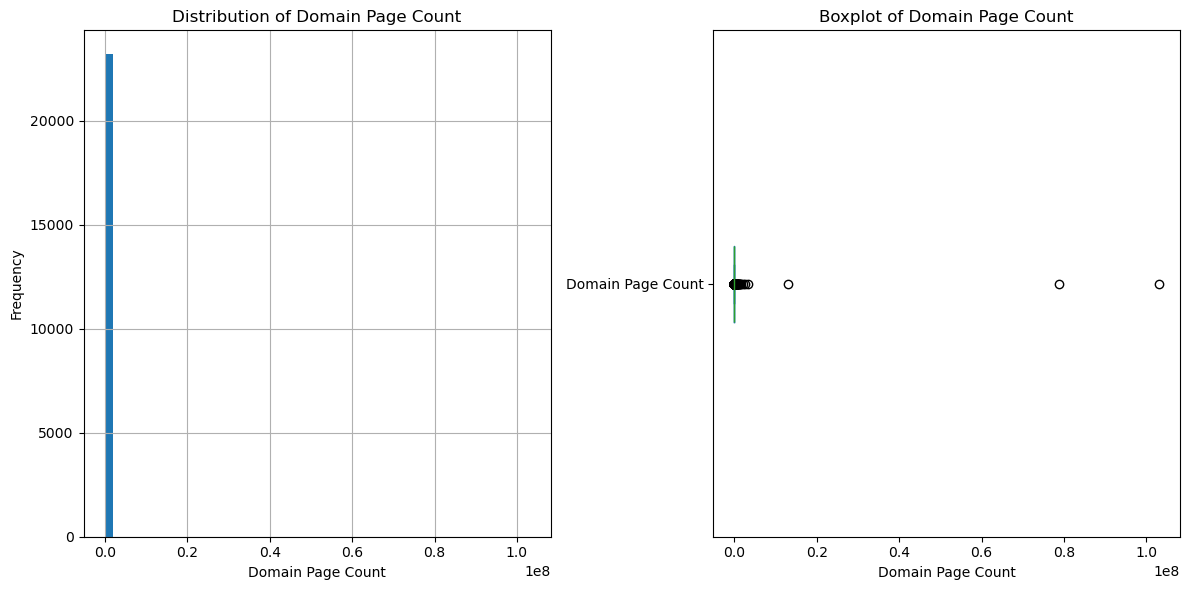

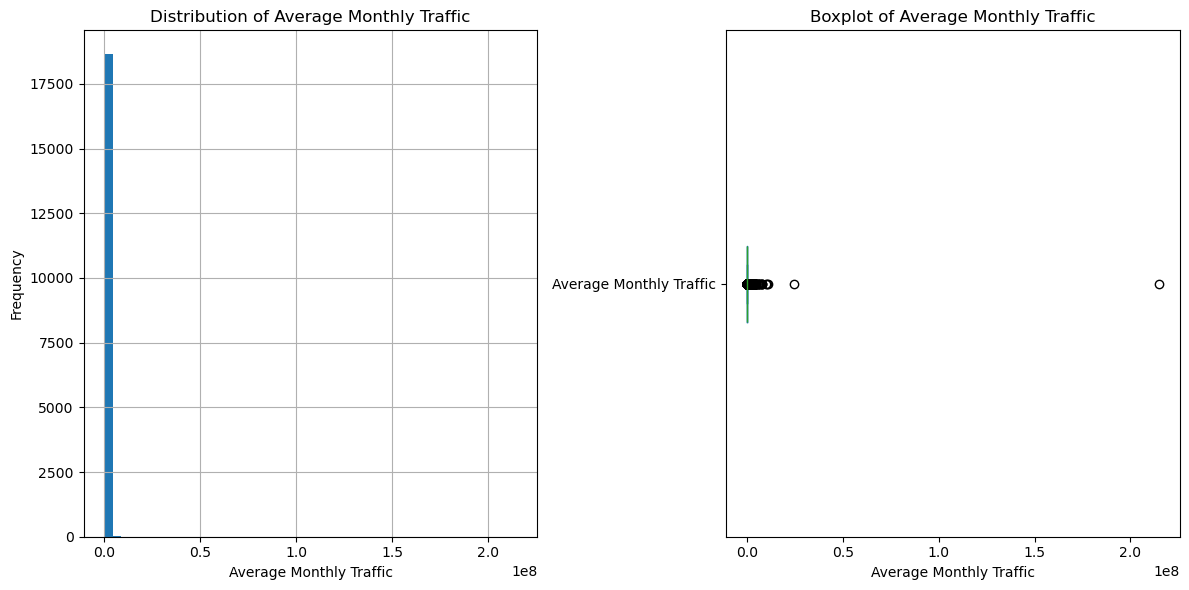

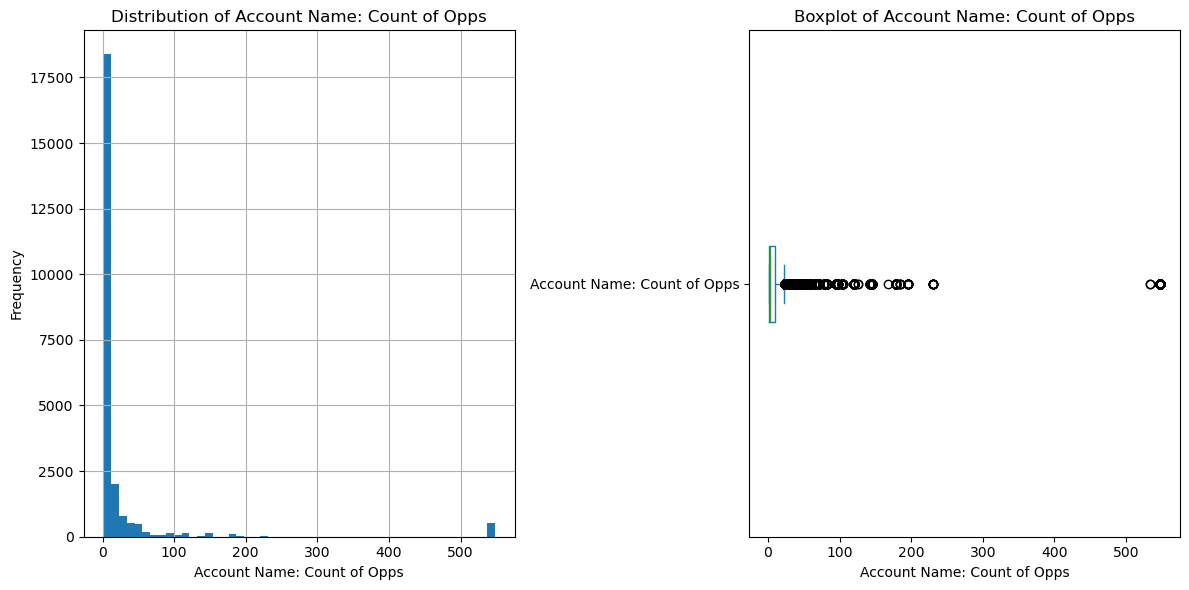

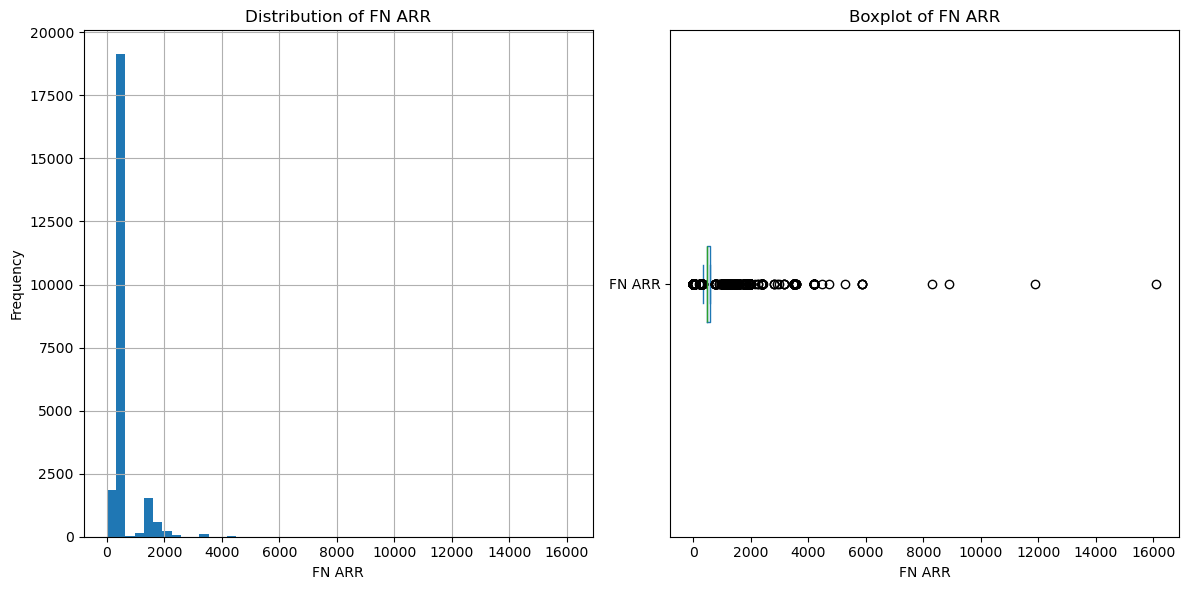

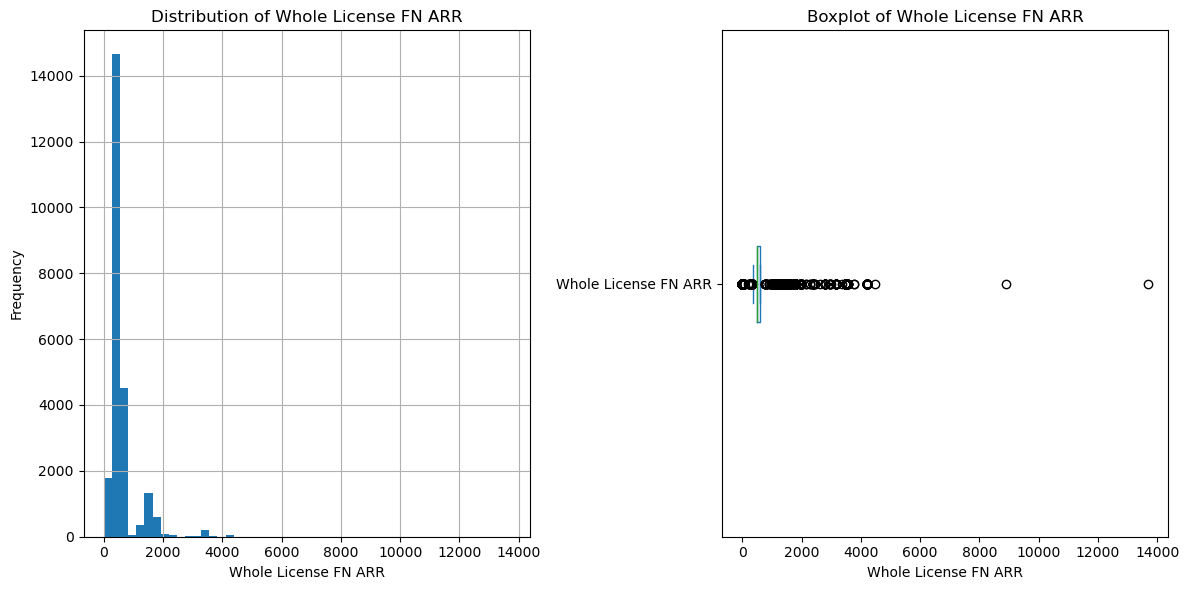

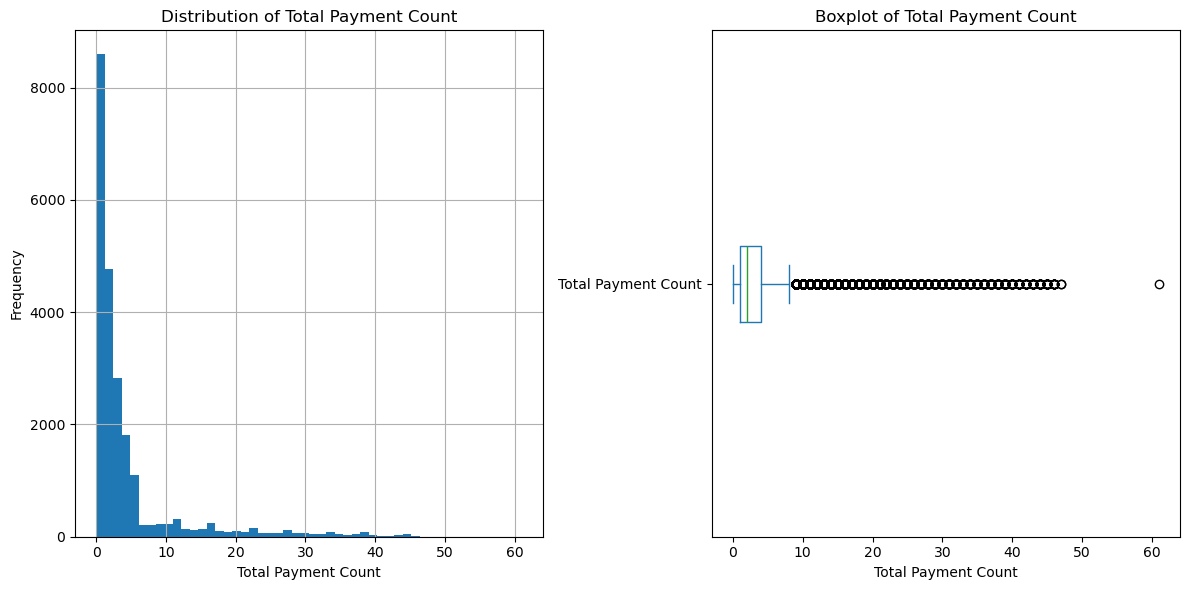

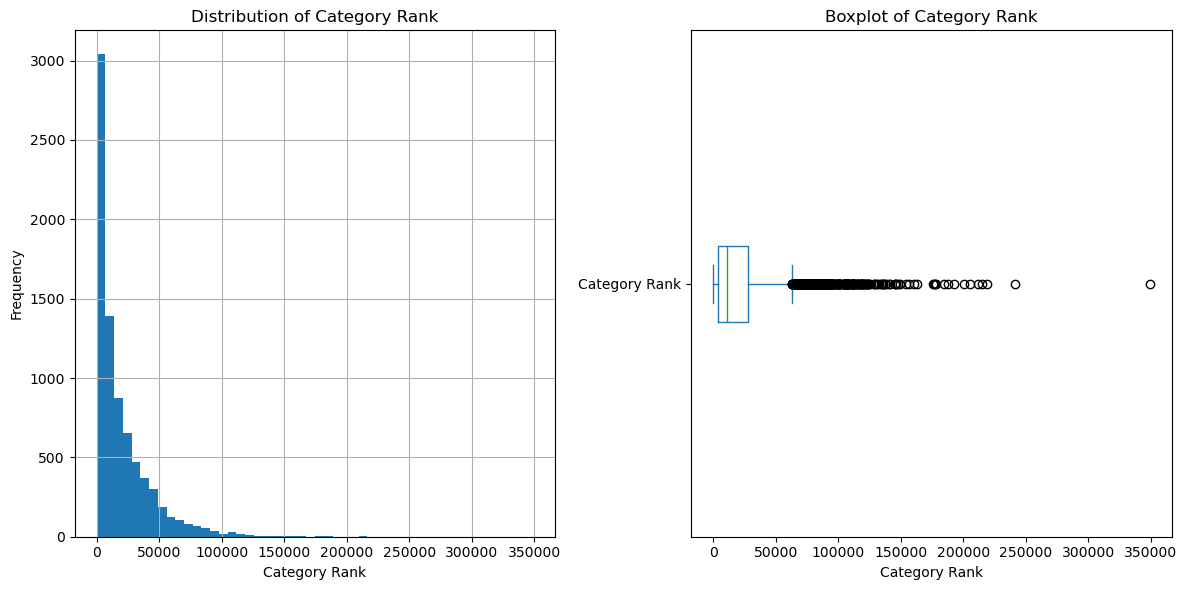

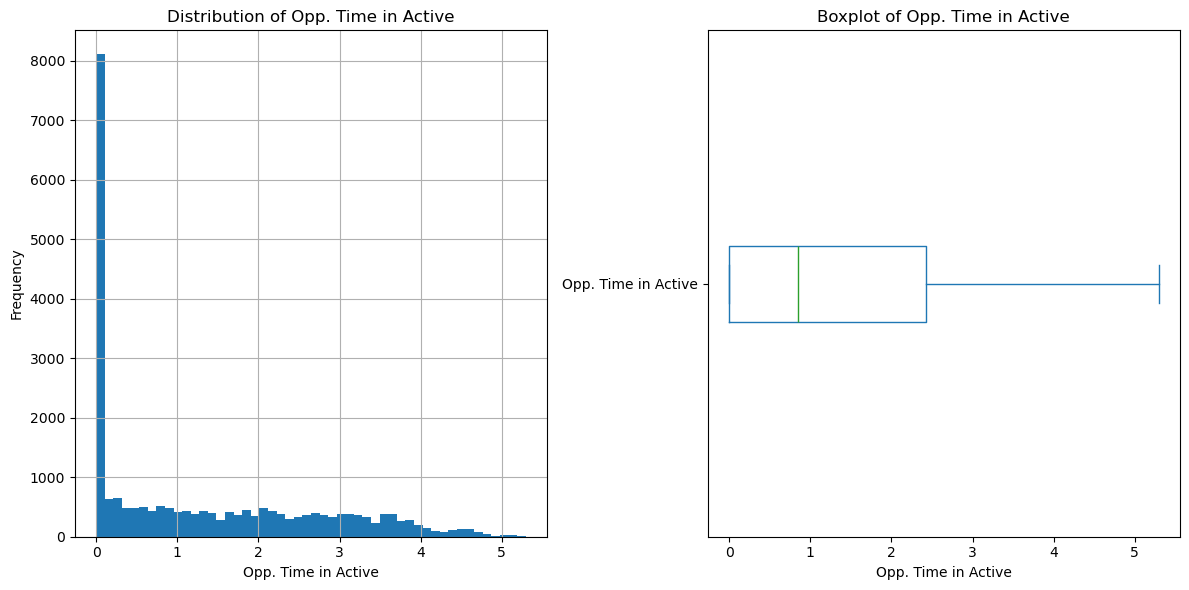

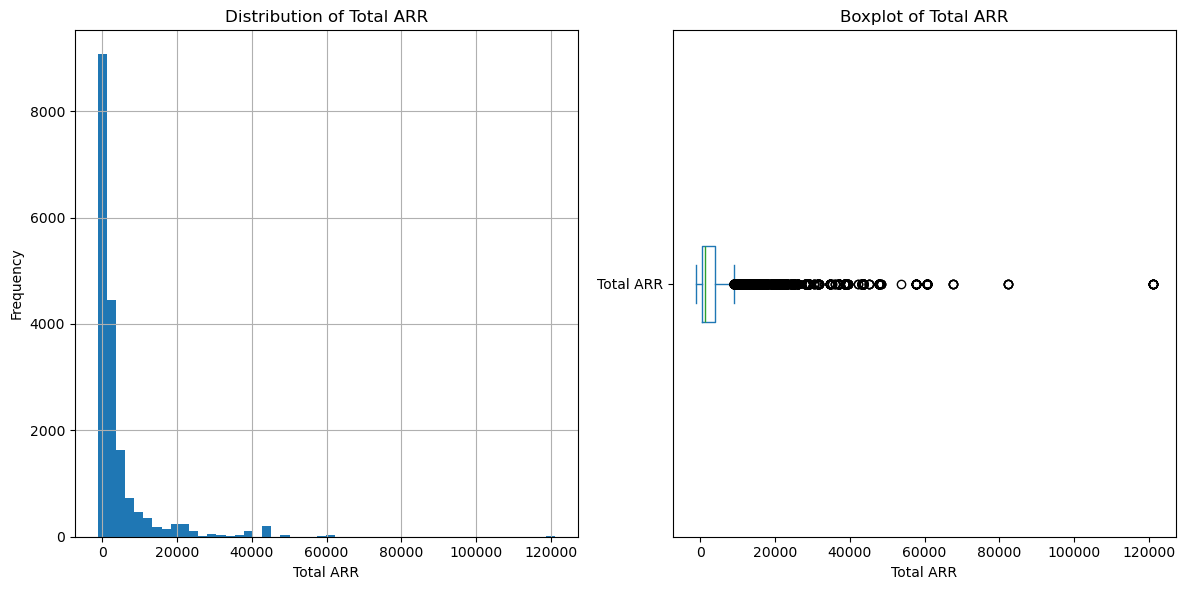

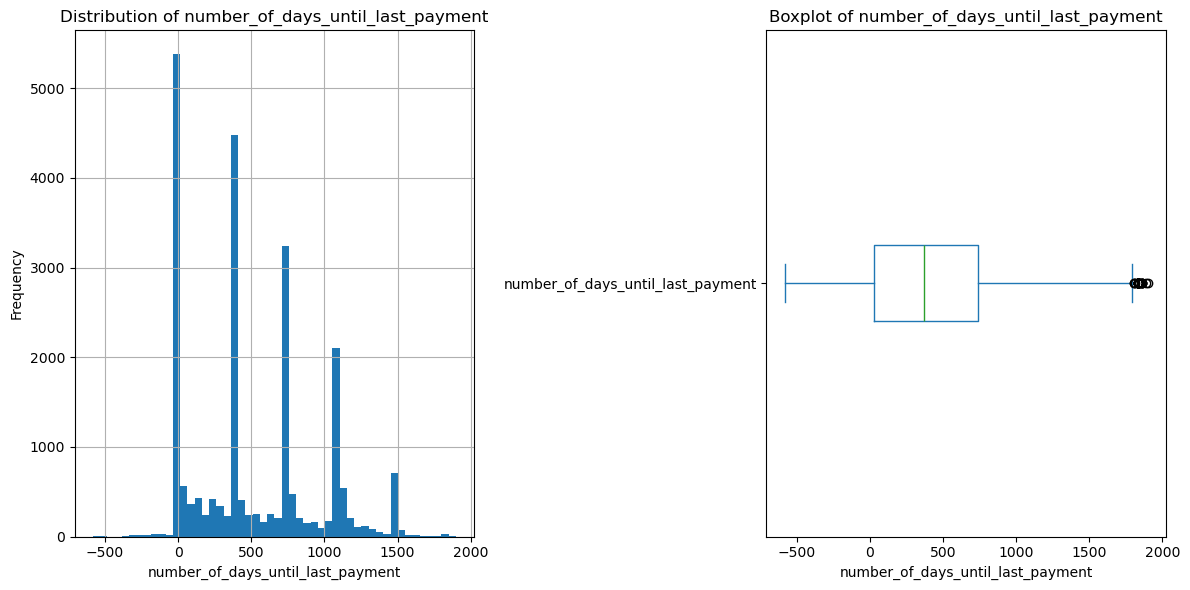

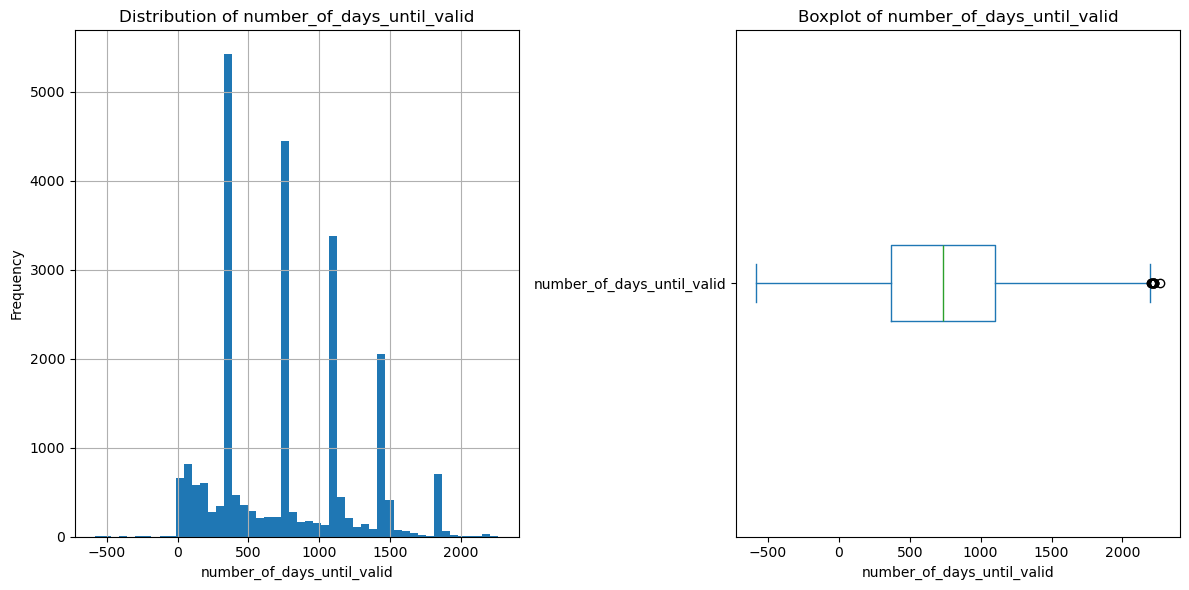

In [ ]:
# List of numerical features with missing values
numerical_features = [
    'Domain Page Count',
    'Average Monthly Traffic',
    'Account Name: Count of Opps',
    'FN ARR',
    'Whole License FN ARR',
    'Total Payment Count',
    'Category Rank',
    'Opp. Time in Active',
    'Total ARR',
    'number_of_days_until_last_payment',
    'number_of_days_until_valid'
]

# Plot histograms and boxplots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    data[feature].hist(bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Horizontal Boxplot
    plt.subplot(1, 2, 2)
    data[feature].plot(kind='box', vert=False)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

We can see that most of the numerical features distributions have extreme values, so we will fill in the missing values with the median and drop the rows with extreme values

In [ ]:
# data = data[data['Domain Page Count'] < 103000000].copy()

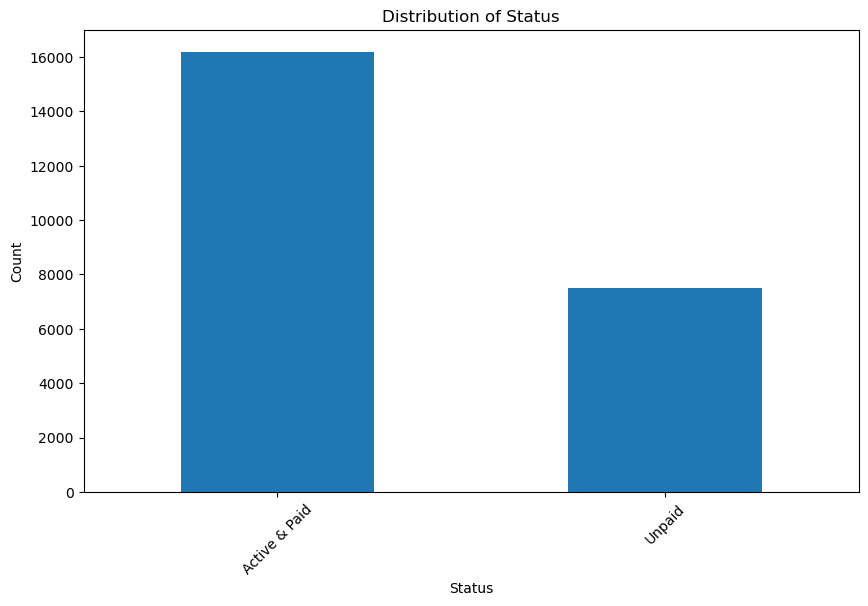

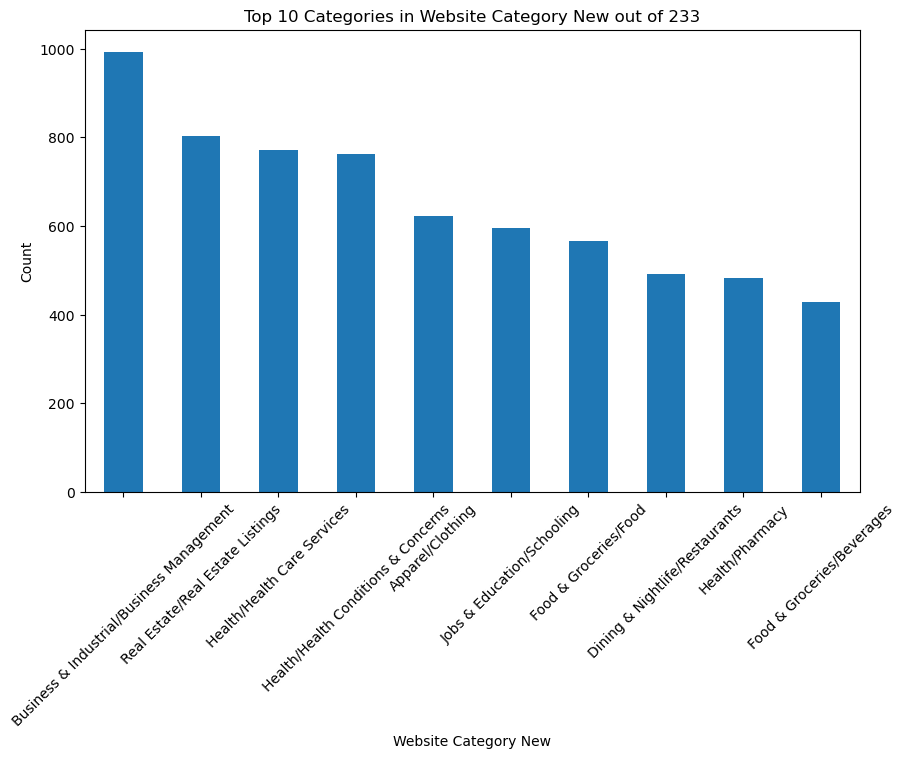

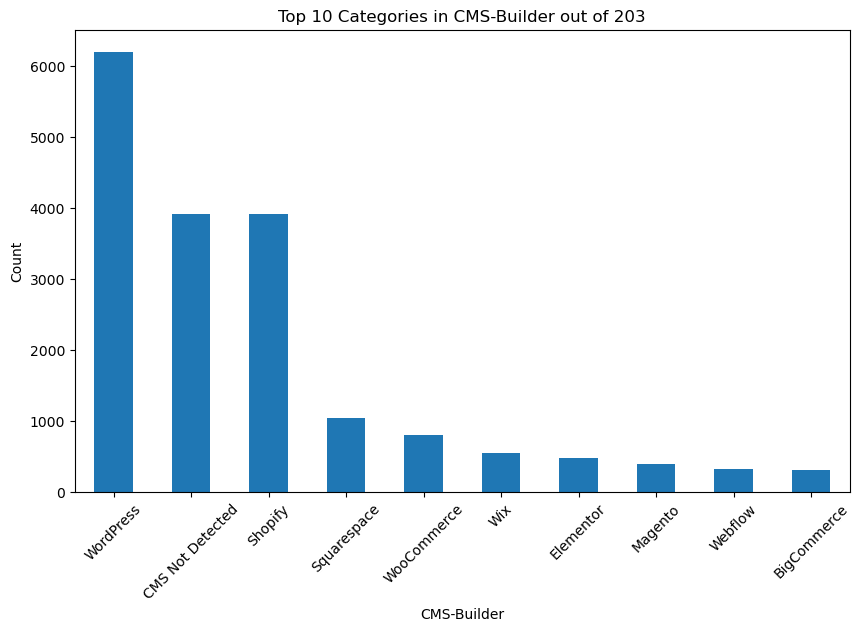

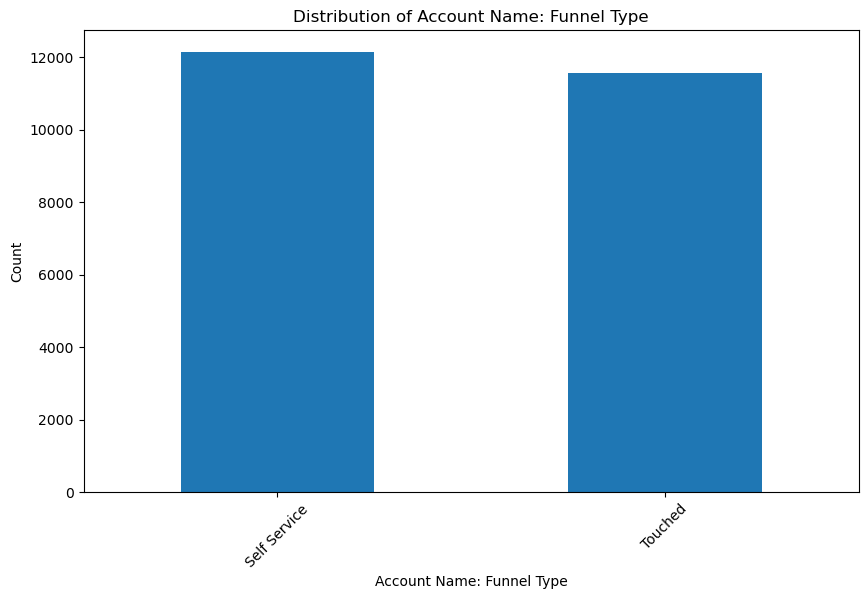

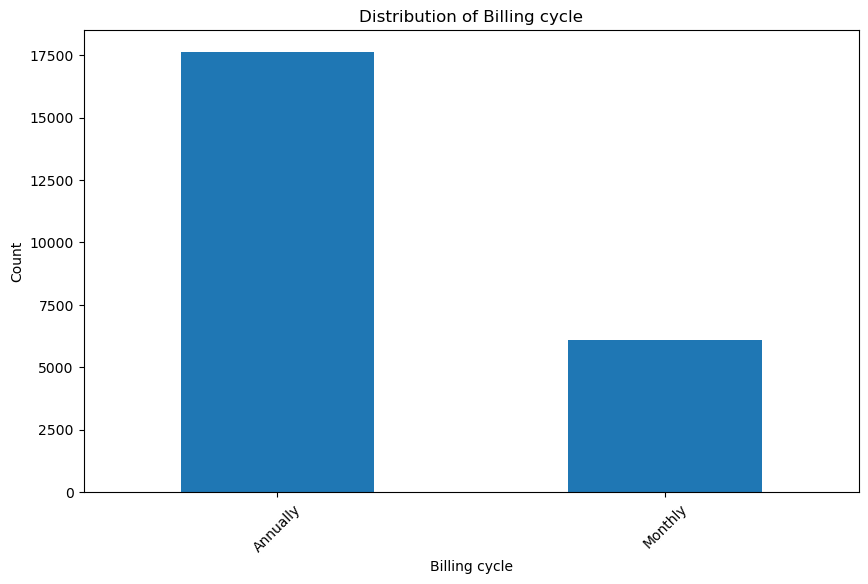

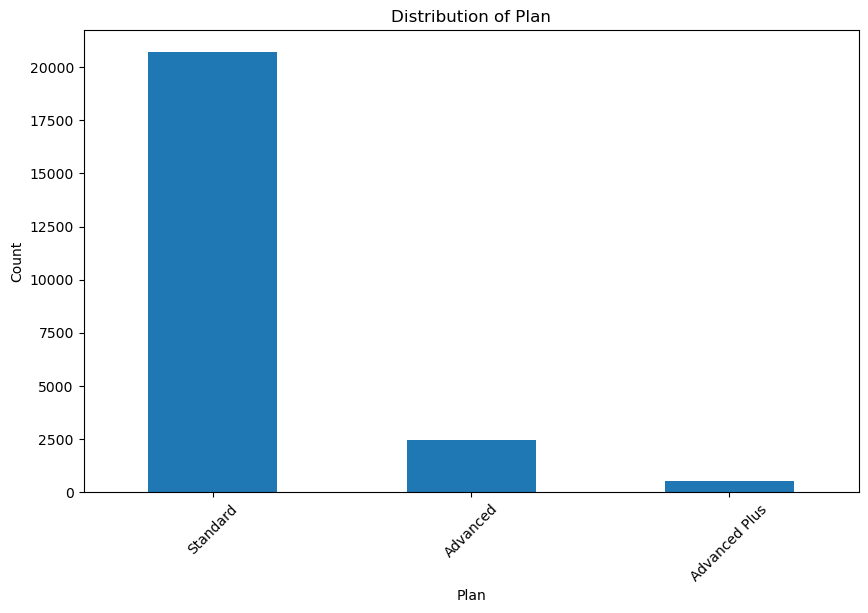

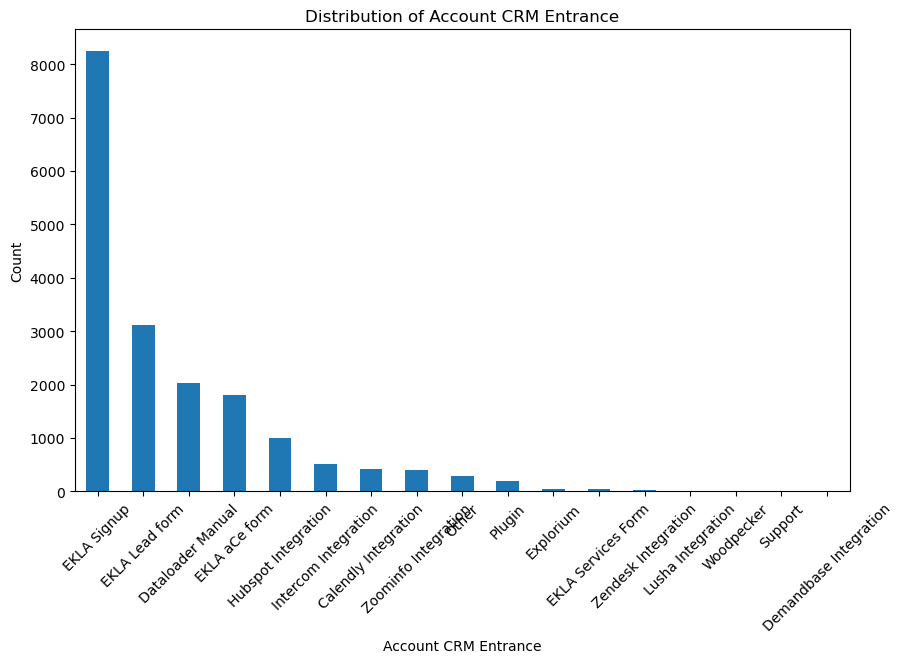

In [ ]:
categorical_features = [
    'Status',
    'Website Category New',
    'CMS-Builder',
    'Account Name: Funnel Type',
    'Billing cycle',
    'Plan',
    'Account CRM Entrance'
]

# Plot bar plots for categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 6))

    if feature in ['Website Category New', 'CMS-Builder']:
        # Get the top 10 categories for the specified feature
        top_10_categories = data[feature].value_counts().head(10)
        top_10_categories.plot(kind='bar')
        plt.title(f'Top 10 Categories in {feature} out of {data[feature].nunique()}')
    else:
        data[feature].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {feature}')

    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

By looking at the distributions of the categorical features, we have decided to fill in missing values with the most frequent value

Let's check for correlations

In [ ]:
# for feature in numerical_features:
#     data[feature].fillna(data[feature].median(), inplace=True)

# # Fill missing values for categorical features with the most frequent value (mode)
# for feature in categorical_features:
#     data[feature].fillna(data[feature].mode()[0], inplace=True)

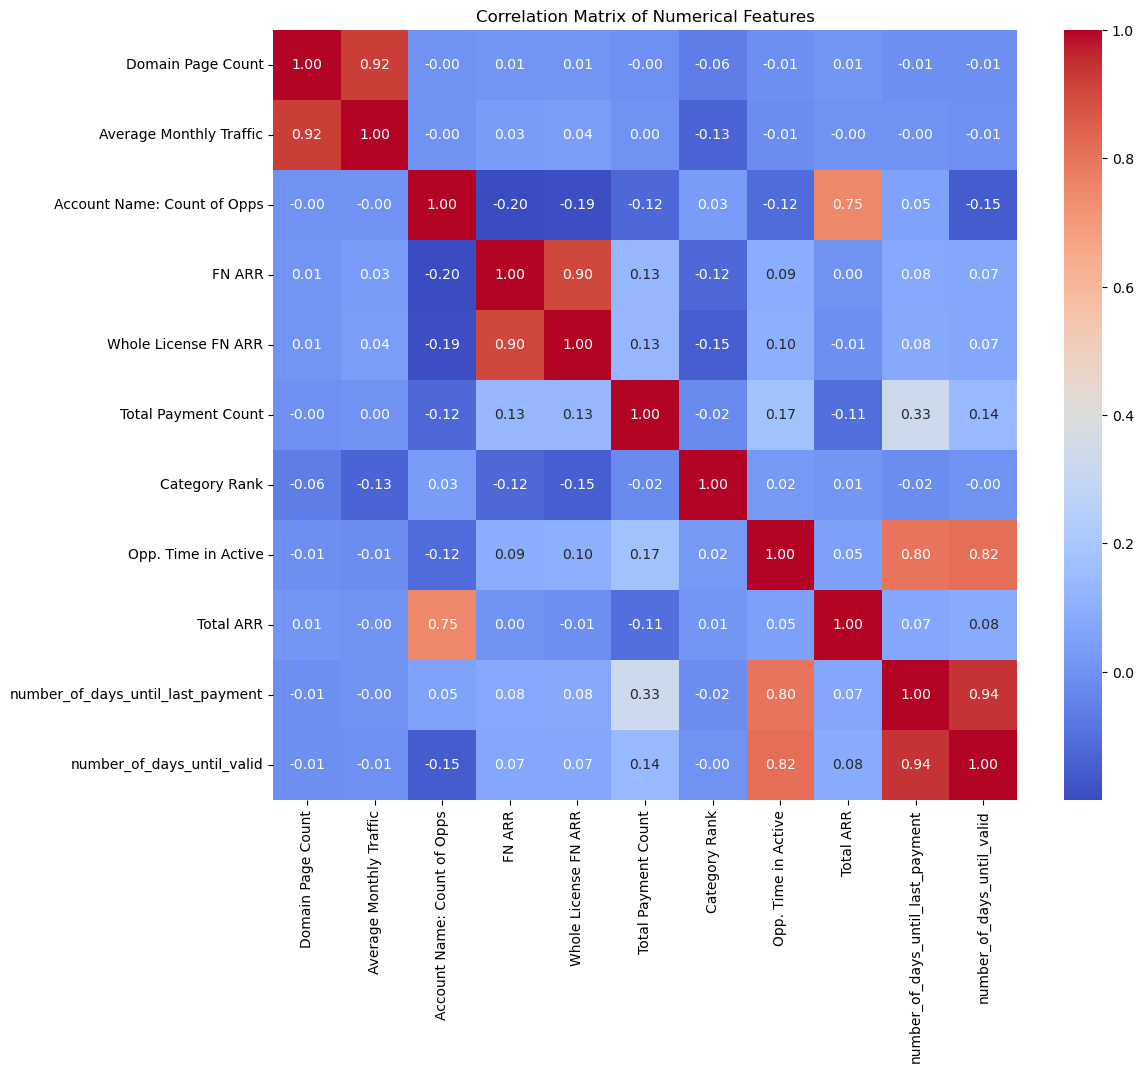

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

We can see some features with a high coorelation to each other:

- Average Monthly Traffic ~ Domain Page Count

- Whole License FN ARR ~ Whole License FN ARR

- number_of_days_until_last_payment ~ Opp. Time in Active

- number_of_days_until_valid ~ Opp. Time in Active

- number_of_days_until_last_payment ~ number_of_days_until_valid

We will implement statistical tests and choose which features will stay

#### Statistical Tests

In [ ]:
from scipy.stats import ttest_ind, chi2_contingency


# Perform t-tests for numerical features
ttest_results = {}
for column in numerical_features:
    if column != 'asked_to_auto_renew_off':
        group1 = data[data['asked_to_auto_renew_off'] == 0][column].dropna()
        group2 = data[data['asked_to_auto_renew_off'] == 1][column].dropna()
        t_stat, p_value = ttest_ind(group1, group2)
        ttest_results[column] = p_value

# Perform chi-square tests for categorical features
chi2_results = {}
for column in categorical_features:
    contingency_table = pd.crosstab(data[column], data['asked_to_auto_renew_off'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi2_results[column] = p_value

# Combine the results into a single dictionary
feature_significance = {**ttest_results, **chi2_results}

# Display the results
feature_significance_df = pd.DataFrame.from_dict(feature_significance, orient='index', columns=['p_value'])
feature_significance_df = feature_significance_df.sort_values(by='p_value')

# Determine which features to keep (p-value < 0.05)
significant_features = [column for column, p_value in feature_significance.items() if p_value < 0.05]

# Filter the dataset to keep only the significant features
filtered_data = data[significant_features + ['asked_to_auto_renew_off']]

# Display the filtered dataset and p-values of features
print("Significant features (p-value < 0.05):", significant_features)
print("\nFeature Significance (p-values):")
print(feature_significance_df)

Significant features (p-value < 0.05): ['Average Monthly Traffic', 'Account Name: Count of Opps', 'FN ARR', 'Whole License FN ARR', 'Category Rank', 'Opp. Time in Active', 'Total ARR', 'number_of_days_until_last_payment', 'number_of_days_until_valid', 'Status', 'Website Category New', 'CMS-Builder', 'Account Name: Funnel Type', 'Billing cycle', 'Plan', 'Account CRM Entrance']

Feature Significance (p-values):
                                         p_value
Status                              0.000000e+00
Opp. Time in Active                 0.000000e+00
Account CRM Entrance               3.538303e-128
Billing cycle                      8.274482e-113
number_of_days_until_valid          1.543474e-67
number_of_days_until_last_payment   1.368309e-51
CMS-Builder                         2.313474e-50
Total ARR                           2.929129e-46
Website Category New                2.196598e-38
Plan                                7.757576e-18
Account Name: Funnel Type           2.593015e-16

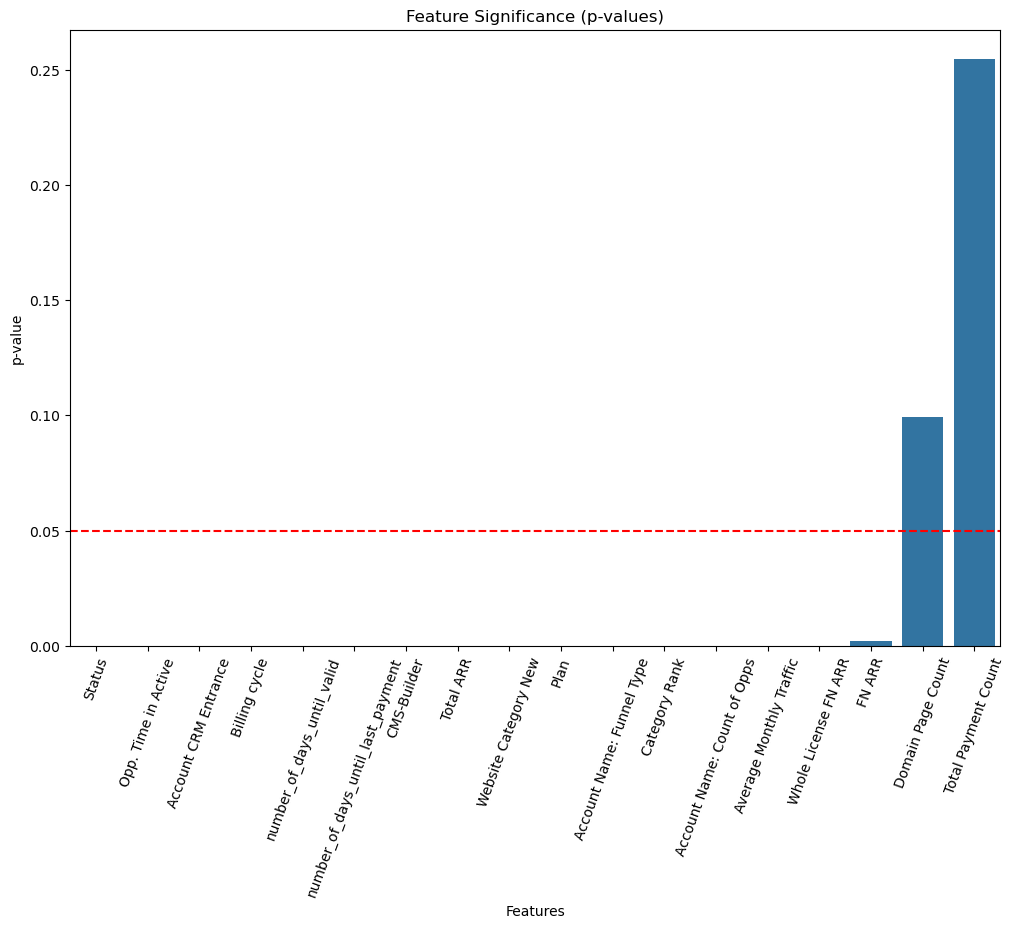

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_significance_df.index, y='p_value', data=feature_significance_df)
plt.axhline(y=0.05, color='r', linestyle='--')  # Add a line at p-value=0.05 for significance level
plt.title('Feature Significance (p-values)')
plt.xlabel('Features')
plt.ylabel('p-value')
plt.xticks(rotation=70)
plt.show()

### Model Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Splitting the data into train and test sets
X = data.drop('asked_to_auto_renew_off', axis=1)
y = data['asked_to_auto_renew_off']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Creating pipelines for numerical and categorical transformations
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Fitting the preprocessor on the training data and transforming both train and test sets
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)




## Class Imbalance

C:\Users\Student\AppData\Local\Temp\ipykernel_8864\3058048133.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_ckd35_distribution.index, y=event_ckd35_distribution.values, palette='viridis', edgecolor='k', alpha=0.7)


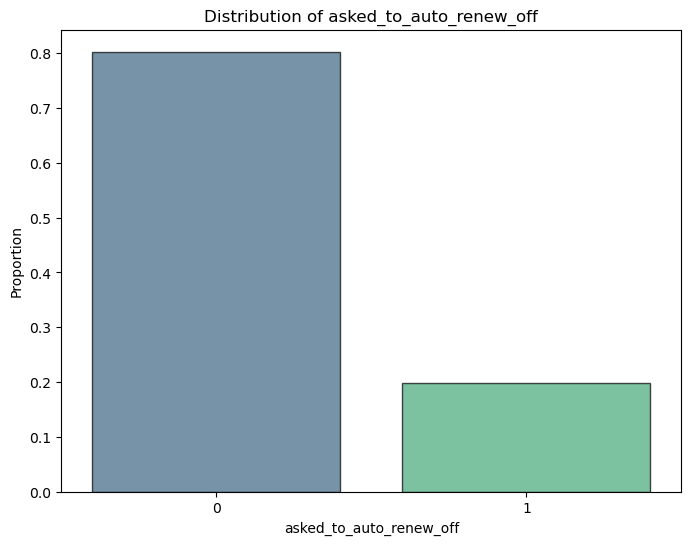

asked_to_auto_renew_off
0    0.802709
1    0.197291
Name: proportion, dtype: float64

In [ ]:
# Check the distribution of the target variable
event_ckd35_distribution = data['asked_to_auto_renew_off'].value_counts(normalize=True)

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=event_ckd35_distribution.index, y=event_ckd35_distribution.values, palette='viridis', edgecolor='k', alpha=0.7)
plt.title('Distribution of asked_to_auto_renew_off')
plt.xlabel('asked_to_auto_renew_off')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['0', '1'])
plt.show()

# Display the distribution values
event_ckd35_distribution


We can see that the target value is highly unbalanced.

we have 3 options:

1. **Over-sampling:**
   - **Technique:** Increase the number of samples in the minority class by duplicating existing samples or generating new ones.
   - **Pros:** Helps balance the class distribution without losing any data.
   - **Cons:** Can lead to overfitting as the model might see the same minority samples multiple times.

2. **Under-sampling:**
   - **Technique:** Decrease the number of samples in the majority class by randomly removing some of the majority samples.
   - **Pros:** Helps balance the class distribution and reduces the size of the dataset, which can speed up training.
   - **Cons:** Risk of losing important information from the majority class, which can reduce model performance.

3. **SMOTE (Synthetic Minority Over-sampling Technique):**
   - **Technique:** Generates synthetic samples for the minority class by interpolating between existing minority samples.
   - **Pros:** Balances the class distribution without duplicating samples, reduces the risk of overfitting.
   - **Cons:** Can introduce noise if synthetic samples are not representative of the minority class.



Due to our domain and lack of data, we cannot afford losing any important information, that's why we won't use under-sampling


#### SMOTE

asked_to_auto_renew_off
0    0.5
1    0.5
Name: proportion, dtype: float64


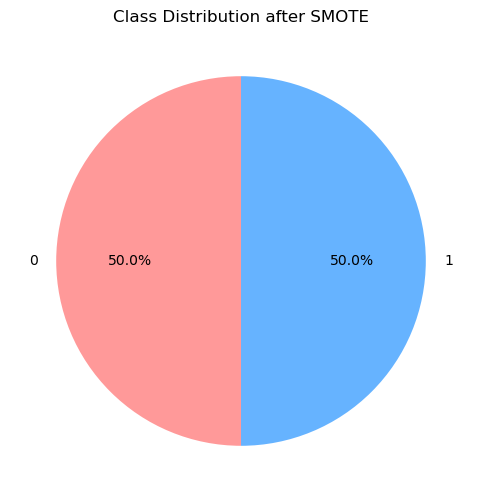

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print(y_train.value_counts(normalize=True))

# Plot the new class distribution as a pie chart
plt.figure(figsize=(8, 6))
y_train.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution after SMOTE')
plt.ylabel('')
plt.show()

SMOTE is a suitable technique as it generates synthetic samples and mitigates the risk of overfitting compared to simple over-sampling. Additionally, it preserves the information from the majority class, unlike under-sampling.

### Recall vs. Precision

- **Recall** (Sensitivity or True Positive Rate):
  - Measures the proportion of actual positives (churn cases) that are correctly identified.
  - High recall means that most of the churn cases are being caught, but it may also include more false positives (non-churn cases predicted as churn).

- **Precision**:
  - Measures the proportion of predicted positives (predicted churn cases) that are actually positive.
  - High precision means that when the model predicts churn, it is usually correct, but it may miss some actual churn cases (higher false negatives).

### Implications for Churn Prediction

1. **High Recall:**
   - Prioritizing recall is important when the cost of missing a churn case (false negative) is very high.
   - Example: If missing a churn case means losing a high-value customer and you want to ensure that you retain as many customers as possible, you might focus on recall.

2. **High Precision:**
   - Prioritizing precision is important when the cost of acting on a false positive (non-churn predicted as churn) is very high.
   - Example: If your churn intervention strategy (e.g., offering discounts, personalized attention) is costly and you want to ensure it is only given to customers who are very likely to churn, you might focus on precision.

### Typical Scenario in Churn Prediction

In most churn prediction scenarios, **recall is often prioritized** because:
- The cost of missing a customer who might churn can be higher than the cost of intervening with a customer who would not churn.
- Businesses usually prefer to cast a wider net to catch as many potential churn cases as possible, even if it means some extra interventions.

### Conclusion

For churn prediction, recall is typically more important because it ensures that we will identify and can potentially act on most customers who are at risk of churning.

According to the our research papers, when dealing with unbalanced data, the models that perform best are tree-based.
We will train 4 models - Logistic Regression, Random Forest, SVM and XGBoost.
For each model we will find the best hyperparameters using GridSearchCV - which gets as an input a model and a list of it's hyperparameters,
perform K-Fold Cross Validation, and returns the best estimator by a score - in our case recall.

In [ ]:
# Logistic Regression

# import time
# import pickle
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression


# logistic_regression = LogisticRegression()
# hyper_parameters = {
#     'C': [0.1, 1, 10],
#     'penalty': ['l2'],
#     'max_iter': [1000000]
# }

# clf = GridSearchCV(logistic_regression, hyper_parameters, cv=4, scoring='recall', n_jobs=-1)
# start_time = time.time()  # Start time
# clf.fit(X_train, y_train)
# end_time = time.time()  # End time
# elapsed_time = end_time - start_time  # Calculate elapsed time
# print(f"Best parameters for Logistic Regression: {clf.best_params_}")
# print(f"Time taken to train Logistic Regression: {elapsed_time:.2f} seconds")
# with open(f'best_model_Logistic Regression.pkl', 'wb') as f:
#     pickle.dump(clf.best_estimator_, f)



Best parameters for Logistic Regression: {'C': 10, 'max_iter': 1000000, 'penalty': 'l2'}
Time taken to train Logistic Regression: 139.39 seconds


C:\Users\Student\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The best hyperparameters are: {'C': 10, 'max_iter': 1000000, 'penalty': 'l2'}

Time taken to train Logistic Regression: 139.39 seconds

The Logistic Regression model is not able to converge towards the minimum.

In [ ]:
# Random Forest

# from sklearn.ensemble import RandomForestClassifier


# random_forest = RandomForestClassifier()
# hyper_parameters = {
#             'n_estimators': [50, 100, 200],
#             'max_depth': [5, 10, None],
#             'min_samples_split': [2, 5, 10]
# }

# clf = GridSearchCV(random_forest, hyper_parameters, cv=4, scoring='recall', n_jobs=-1)
# start_time = time.time()  # Start time
# clf.fit(X_train, y_train)
# end_time = time.time()  # End time
# elapsed_time = end_time - start_time  # Calculate elapsed time
# print(f"Best parameters for Random Forest: {clf.best_params_}")
# print(f"Time taken to train Random Forest: {elapsed_time:.2f} seconds")
# with open(f'best_model_Random_Forest_1.pkl', 'wb') as f:
#     pickle.dump(clf.best_estimator_, f)


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Time taken to train Random Forest: 162.40 seconds


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}

Time taken to train Random Forest: 162.40 seconds



In [ ]:
# # SVM

# from sklearn.svm import SVC


# svm = SVC(probability=True)
# hyper_parameters = {
#             'C': [0.1, 1, 10],
#             'kernel': ['linear', 'rbf']
# }

# clf = GridSearchCV(svm, hyper_parameters, cv=4, scoring='recall', n_jobs=-1)
# start_time = time.time()  # Start time
# clf.fit(X_train, y_train)
# end_time = time.time()  # End time
# elapsed_time = end_time - start_time  # Calculate elapsed time
# print(f"Best parameters for SVM: {clf.best_params_}")
# print(f"Time taken to train SVM: {elapsed_time:.2f} seconds")
# with open(f'best_model_SVM.pkl', 'wb') as f:
#     pickle.dump(clf.best_estimator_, f)


In [ ]:
# !pip install xgboost

In [ ]:
# import pickle
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC

# # Define the models and hyperparameters
# models = {
#     'Logistic Regression': {
#         'model': LogisticRegression(),
#         'params': {
#             'C': [0.1, 1, 10],
#             'penalty': ['l2'],
#             # 'solver': ['lbfgs', 'liblinear']
#         }
#     # },
#     # 'XGBoost': {
#     #     'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
#     #     'params': {
#     #         'n_estimators': [50, 100, 200],
#     #         'max_depth': [3, 6, 10],
#     #         'learning_rate': [0.01, 0.1, 0.2],
#     #         'subsample': [0.6, 0.8, 1.0]
#     #     }
#     },
#     'Random Forest': {
#         'model': RandomForestClassifier(),
#         'params': {
#             'n_estimators': [50, 100, 200],
#             'max_depth': [5, 10, None],
#             'min_samples_split': [2, 5, 10]
#         }
#     },
#     'SVM': {
#         'model': SVC(probability=True),
#         'params': {
#             'C': [0.1, 1, 10],
#             'kernel': ['linear', 'rbf']
#         }
#     }
# }

# # Perform GridSearchCV for each model
# best_models = {}
# for model_name, model_info in models.items():
#     clf = GridSearchCV(model_info['model'], model_info['params'], cv=10, scoring='recall', n_jobs=-1)
#     clf.fit(X_train, y_train)
#     best_models[model_name] = clf.best_estimator_
#     print(f"Best parameters for {model_name}: {clf.best_params_}")
#     with open(f'best_model_{model_name.replace(" ", "_")}.pkl', 'wb') as f:
#         pickle.dump(clf.best_estimator_, f)

In [ ]:
# import time
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC

# # Define the models and hyperparameters
# models = {
#     'Logistic Regression': {
#         'model': LogisticRegression(),
#         'params': {
#             'C': [0.1, 1, 10],
#             'penalty': ['l2'],
#             'solver': ['lbfgs', 'liblinear']
#         }
#     }
# }

# # Perform GridSearchCV for each model and measure the time taken
# best_models = {}
# for model_name, model_info in models.items():
#     start_time = time.time()  # Start time
#     clf = GridSearchCV(model_info['model'], model_info['params'], cv=10, scoring='recall', n_jobs=-1)
#     clf.fit(X_train_resampled, y_train_resampled)
#     end_time = time.time()  # End time

#     elapsed_time = end_time - start_time  # Calculate elapsed time
#     best_models[model_name] = clf.best_estimator_

#     print(f"Best parameters for {model_name}: {clf.best_params_}")
#     print(f"Time taken to train {model_name}: {elapsed_time:.2f} seconds")


In [ ]:


# models = {
#     'Logistic Regression': {
#         'model': LogisticRegression(),
#         'params': {
#             'C': [0.1, 1, 10],
#             'penalty': ['l2'],
#             # 'solver': ['lbfgs', 'liblinear']
#         }

In [ ]:
# from sklearn.svm import SVC


# models = {
#     'SVM': {
#         'model': SVC(probability=True),
#         'params': {
#             'C': [0.1, 1, 10],
#             'kernel': ['linear', 'rbf']
#     }
# }
# }
# for model_name, model_info in models.items():
#     clf = GridSearchCV(model_info['model'], model_info['params'], cv=10, scoring='recall', n_jobs=-1)
#     clf.fit(X_train, y_train)
#     best_models[model_name] = clf.best_estimator_
#     print(f"Best parameters for {model_name}: {clf.best_params_}")
#     with open(f'best_model_{model_name.replace(" ", "_")}.pkl', 'wb') as f:
#         pickle.dump(clf.best_estimator_, f)

In [ ]:
import pickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

best_models = {}

with open("best_model_Logistic_Regression.pkl", 'rb') as file:
    best_models['Logistic_Regression'] = pickle.load(file)
with open("best_model_Random_Forest.pkl", 'rb') as file:
    best_models['Random_Forest'] = pickle.load(file)
with open("best_model_SVM.pkl", 'rb') as file:
    best_models['SVM'] = pickle.load(file)
with open("best_model_XGBoost.pkl", 'rb') as file:
    best_models['XGBoost'] = pickle.load(file)

C:\Users\Student\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Student\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:39:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences

Classification report for Logistic_Regression:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      3805
           1       0.69      0.02      0.04       935

    accuracy                           0.80      4740
   macro avg       0.75      0.51      0.46      4740
weighted avg       0.78      0.80      0.72      4740

Classification report for Random_Forest:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3805
           1       0.71      0.81      0.76       935

    accuracy                           0.90      4740
   macro avg       0.83      0.87      0.85      4740
weighted avg       0.90      0.90      0.90      4740

Classification report for SVM:
              precision    recall  f1-score   support

           0       0.87      0.21      0.34      3805
           1       0.21      0.87      0.34       935

    accuracy                           0.34      4740
   macro 

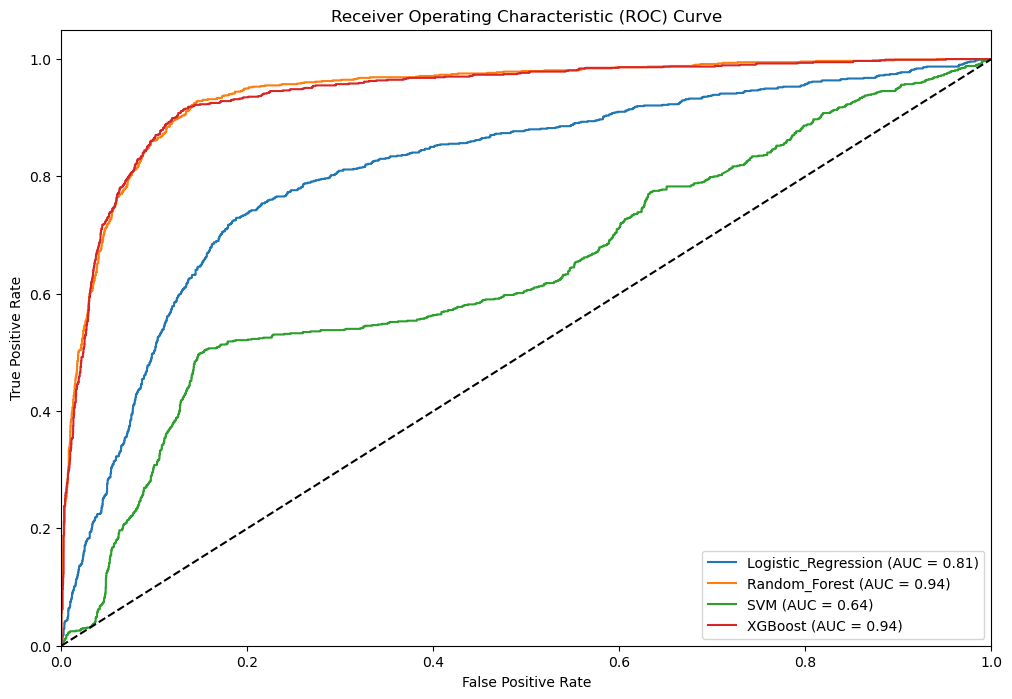

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, RocCurveDisplay

# Evaluate each model on the test set
plt.figure(figsize=(12, 8))


for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    print(f"Classification report for {model_name}:")
    print(classification_report(y_test, y_pred))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()